<a href="https://colab.research.google.com/github/yizhang-polu/github-pages-with-jekyll/blob/master/notebooks%20/unit4/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.0 MB/s eta 0:00:00


In [ ]:
# Imports and device
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
env = gym.make('CartPole-v1')
env.reset(seed=0)  # Seed is now passed to reset() in new Gymnasium API
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)


In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_size: int = 128):
        super().__init__()
        # TODO: define layers (e.g., Linear -> ReLU -> Linear -> logits)
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: forward pass, return action probabilities (softmax)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        probs = F.softmax(logits, dim=-1)
        return probs

    @torch.no_grad()
    def act(self, state_np: np.ndarray):
        state = torch.as_tensor(state_np, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return int(action.item()), m.log_prob(action).squeeze(0)  # log_prob returned for API symmetry

In [ ]:
def compute_discounted_returns(rewards, gamma: float = 0.99, normalize: bool = True):
    returns = []
    g = 0.0
    for r in reversed(rewards):
        g = r + gamma * g
        returns.append(g)
    returns.reverse()
    returns = torch.as_tensor(returns, dtype=torch.float32, device=DEVICE)
    if normalize:
        mean = returns.mean()
        std = returns.std().clamp_min(1e-8)
        returns = (returns - mean) / std
    return returns

In [ ]:
# Training loop (fill the TODOs)

def train(env_id: str = "CartPole-v1",
          hidden_size: int = 128,
          lr: float = 1e-2,
          gamma: float = 0.99,
          episodes: int = 600,
          normalize_returns: bool = True,
          seed: int = 42):
    env = gym.make(env_id)
    env.action_space.seed(seed)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    policy = Policy(obs_dim, act_dim, hidden_size).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    ep_rewards = []
    smoothed = []

    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        log_probs = []
        rewards = []

        done = False
        while not done:
            state_t = torch.as_tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            probs = policy(state_t) # graident tracking
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action).squeeze(0)

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(float(reward))
            state = next_state

        returns = compute_discounted_returns(rewards, gamma, normalize_returns)

        # TODO: compute policy loss L = -sum(log_pi(a_t|s_t) * G_t)
        log_probs_t = torch.stack(log_probs)
        loss = -(log_probs_t * returns).sum()

        optimizer.zero_grad()
        loss.backward()

        #print(policy.fc1.weight[0, 0].item())
        optimizer.step()
        #print(policy.fc1.weight[0, 0].item())
        #print(policy.fc1.weight.grad)

        total_reward = sum(rewards)
        ep_rewards.append(total_reward)
        if len(smoothed) == 0:
            smoothed.append(total_reward)
        else:
            smoothed.append(0.95 * smoothed[-1] + 0.05 * total_reward)

        if (ep + 1) % 20 == 0:
            last50 = ep_rewards[-50:]
            avg50 = sum(last50) / max(1, len(last50))
            print(f"Episode {ep+1:4d} | reward={total_reward:6.1f} | avg50={avg50:6.1f} | loss={loss.item():.3f}")

    env.close()
    return policy, ep_rewards, smoothed



In [ ]:
# Evaluation helper

@torch.no_grad()
def evaluate(policy: Policy, env_id: str = "CartPole-v1", episodes: int = 20, seed: int = 123): # seed in evaluation can be randomly set
    env = gym.make(env_id)
    env.action_space.seed(seed)
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        done = False
        ep_ret = 0.0
        while not done:
            s = torch.as_tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            probs = policy(s)
            action = torch.argmax(probs, dim=-1).item() # exploit according to the policy during evaluation
            state, r, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_ret += float(r)
        rewards.append(ep_ret)
    env.close()
    mean_r = float(np.mean(rewards))
    std_r = float(np.std(rewards))
    return mean_r, std_r



Episode   20 | reward=  21.0 | avg50=  20.8 | loss=-0.276
Episode   40 | reward=  57.0 | avg50=  40.3 | loss=-1.341
Episode   60 | reward=  30.0 | avg50=  43.6 | loss=0.131
Episode   80 | reward=  35.0 | avg50=  52.8 | loss=2.026
Episode  100 | reward= 104.0 | avg50=  58.0 | loss=-4.918
Episode  120 | reward= 245.0 | avg50= 128.2 | loss=-5.582
Episode  140 | reward=  61.0 | avg50= 150.5 | loss=3.914
Episode  160 | reward= 196.0 | avg50= 147.5 | loss=-9.179
Episode  180 | reward= 289.0 | avg50= 114.4 | loss=-6.480
Episode  200 | reward= 500.0 | avg50= 277.9 | loss=10.775
Episode  220 | reward= 500.0 | avg50= 427.2 | loss=-7.443
Episode  240 | reward= 500.0 | avg50= 500.0 | loss=-5.992
Episode  260 | reward= 500.0 | avg50= 463.5 | loss=-8.993
Episode  280 | reward= 500.0 | avg50= 428.7 | loss=-13.189
Episode  300 | reward=  94.0 | avg50= 311.2 | loss=1.945
Episode  320 | reward= 121.0 | avg50= 195.7 | loss=2.049
Episode  340 | reward=  97.0 | avg50= 151.3 | loss=-0.854
Episode  360 | rew

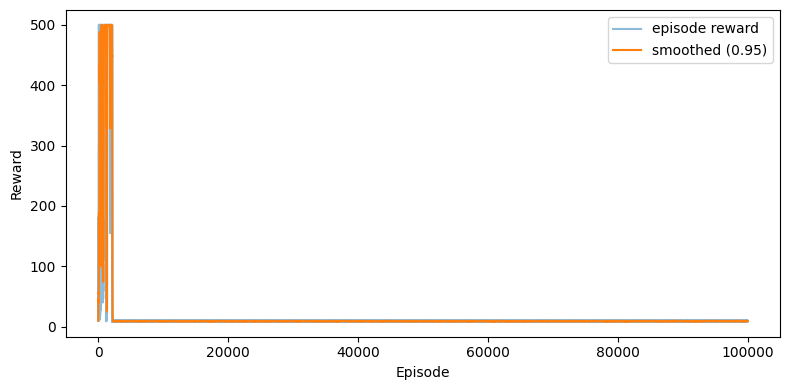

Saved: models/cartpole_policy.pt
Evaluation over 20 eps: mean=9.2 std=0.7


In [ ]:
# Train, plot, save, evaluate

HIDDEN = 128
LR = 1e-2
GAMMA = 0.99
EPISODES = 100000
NORMALIZE_RETURNS = True

policy, rewards, smoothed = train(
    env_id="CartPole-v1",
    hidden_size=HIDDEN,
    lr=LR,
    gamma=GAMMA,
    episodes=EPISODES,
    normalize_returns=NORMALIZE_RETURNS,
    seed=SEED,
)

# Plot training curve
plt.figure(figsize=(8,4))
plt.plot(rewards, alpha=0.5, label="episode reward")
plt.plot(smoothed, label="smoothed (0.95)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.savefig("training_curve.png", dpi=120)
plt.show()

# Save weights
os.makedirs("models", exist_ok=True)
ckpt_path = "models/cartpole_policy.pt"
torch.save({
    "state_dict": policy.state_dict(),
    "obs_dim": 4,
    "act_dim": 2,
    "hidden": HIDDEN,
}, ckpt_path)
print("Saved:", ckpt_path)

# Evaluate greedy policy
mean_r, std_r = evaluate(policy, "CartPole-v1", episodes=20, seed=SEED+1000)
print(f"Evaluation over 20 eps: mean={mean_r:.1f} std={std_r:.1f}")